In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import pymysql
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

## Step1: data load

### DB 연동

In [9]:
conn = pymysql.connect(host = "127.0.0.1", user = [USER], passwd = [PASSWORD], db = [DATABASE], cursorclass = pymysql.cursors.DictCursor)
cur = conn.cursor()

cur.execute("show databases")
print(cur.fetchall())
cur.execute("use CLI")

[{'Database': 'information_schema'}, {'Database': 'CLI'}, {'Database': 'MusicBank'}, {'Database': 'mysql'}, {'Database': 'mytestdb'}, {'Database': 'performance_schema'}, {'Database': 'sys'}]


0

### table date loading

In [10]:
query = """ 
select * from news_counting ;
"""
cur.execute(query)
news_df = pd.DataFrame(list(cur.fetchall())).drop(['id'], axis=1)
news_df.head()

,year,month,day,keyword1,keyword2,keyword3,keyword4,keyword5
0,2015,9,7,737,399,273,236,135
1,2015,9,14,701,513,274,147,226
2,2015,9,21,575,267,231,216,111
3,2015,9,28,480,248,173,129,79
4,2015,10,5,576,262,204,87,109


In [11]:
query = """ 
select * from portal_trends_ratio ;
"""
cur.execute(query)
portal_df = pd.DataFrame(list(cur.fetchall()))
portal_df = portal_df[['year', 'month', 'day', 'google', 'naver']][17:]

# 카카오변수 제외, 구글/네이버를 활용하기위해 네이버변수가 값을 갖는 2016년 1월부터 데이터 사용
portal_df.head()


,year,month,day,google,naver
17,2016,1,4,53.0,26.05846
18,2016,1,11,58.0,25.16599
19,2016,1,18,74.0,27.38639
20,2016,1,25,59.0,24.72622
21,2016,2,1,63.0,23.01888


In [12]:
## response y: CCSI(소비자심리지수)
query = """ 
select * from ccsi ;
"""
cur.execute(query)
conn.close()
cur.close()
ccsi = pd.DataFrame(list(cur.fetchall()))[4:].reset_index(drop = True)
# X와 기간을 맞춤
ccsi.head()

,id,year,month,ccsi
0,5,2016,1,99.5
1,6,2016,2,97.2
2,7,2016,3,99.5
3,8,2016,4,101.1
4,9,2016,5,98.6


## Step2. X, y dataframe
* response: CCSI
* predictors: keyword1 ~ 5, google, naver

### predictors df(X: 뉴스카운팅, 포털트렌드 변수)생성

In [14]:
predictors = pd.merge(news_df, portal_df)
predictors.head()

,year,month,day,keyword1,keyword2,keyword3,keyword4,keyword5,google,naver
0,2016,1,4,825,419,437,986,168,53.0,26.05846
1,2016,1,11,770,348,351,626,182,58.0,25.16599
2,2016,1,18,918,422,441,445,147,74.0,27.38639
3,2016,1,25,1067,425,567,383,148,59.0,24.72622
4,2016,2,1,899,341,485,289,110,63.0,23.01888


In [15]:
"""
달의 마지막주인지 확인하는 function
"""
def isLastWeekOfThisMonth(X, index):
    if(index == (len(X) - 1)):
        return True
    if ( X.iloc[index].month != X.iloc[index + 1].month ):
        return True
    return False


In [16]:
"""
같은 달의 주차별 데이터들을 저장하는 list를 초기화하는 function
"""
def initializeStacks():
    global keyword1_stack, keyword2_stack, keyword3_stack, keyword4_stack, keyword5_stack, google_stack, naver_stack
    keyword1_stack = []
    keyword2_stack = []
    keyword3_stack = []
    keyword4_stack = []
    keyword5_stack = []
    google_stack = []
    naver_stack = []


In [17]:
"""
달의 마지막 주차이면, 해당 달의 데이터들의 평균값들을 하나의 record로 갖는 dataframe 생성
"""
def getXdataframe(X):
    initializeStacks()
    X_monthly = pd.DataFrame()
    for i in range(len(X)):
        keyword1_stack.append(X.iloc[i].keyword1)
        keyword2_stack.append(X.iloc[i].keyword2)
        keyword3_stack.append(X.iloc[i].keyword3)
        keyword4_stack.append(X.iloc[i].keyword4)
        keyword5_stack.append(X.iloc[i].keyword5)
        google_stack.append(X.iloc[i].google)
        naver_stack.append(X.iloc[i].naver)

        if ( isLastWeekOfThisMonth(X, i) ):
            
            # 달의 마지막 주차이면, 해당 달의 데이터들의 평균값을 저장. 
            keyword1 = np.mean(keyword1_stack)
            keyword2 = np.mean(keyword2_stack)
            keyword3 = np.mean(keyword3_stack)
            keyword4 = np.mean(keyword4_stack)
            keyword5 = np.mean(keyword5_stack)
            google = np.mean(google_stack)
            naver = np.mean(naver_stack)
            
            record = pd.Series([int(X.iloc[i].year), int(X.iloc[i].month), keyword1, keyword2, keyword3, keyword4, keyword5, google, naver])
            row_df = pd.DataFrame([record])
            X_monthly = pd.concat([X_monthly, row_df], ignore_index=True)
            initializeStacks()
            
    return X_monthly


In [20]:
"""
df column명 정해주는 function
"""
def renameXdataframe(X):
    X.rename(columns={0: 'year', 1: 'month', 2: 'keyword1', 3: 'keyword2', 4: 'keyword3', 5: 'keyword4', 6: 'keyword5', 7: 'google', 8: 'naver'}, inplace = True)
    return X.astype({"year": int, "month": int})


In [22]:
X_df = getXdataframe(predictors)
X_df = renameXdataframe(X_df)
X_df.head()

,year,month,keyword1,keyword2,keyword3,keyword4,keyword5,google,naver
0,2016,1,895.00,403.50,449.0,610.00,161.25,61.00,25.834265
1,2016,2,811.80,396.60,359.2,341.60,124.40,60.00,24.908160
2,2016,3,667.25,267.00,293.0,98.50,107.50,67.75,28.296107
3,2016,4,718.25,258.25,367.0,142.25,116.75,69.00,25.843962
4,2016,5,656.80,290.40,387.4,106.20,131.00,69.80,26.812964


## Step3. Modeling
### split train and test

In [24]:
df = pd.merge(X_df, ccsi)
X = df[['keyword1', 'keyword2', 'keyword3', 'keyword4', 'keyword5', 'google', 'naver']] # X: 예측변수 dataframe
y = df[['ccsi']] # y: 반응변수 dataframe

In [25]:
# CV를 활용하기 위해, validate set은 따로 분할하지 않는다.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state= 4)

### model 1. multiple linear regression

* model fitting

In [26]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train) # 모델 적합

LinearRegression()

In [27]:
print('Intercept: \n', model_lr.intercept_) # beta0
print('Coefficients: \n', model_lr.coef_) # betas

Intercept: 
 [131.56781429]
Coefficients: 
 [[-0.02073637  0.01463917 -0.0232504   0.01115219 -0.04357569 -0.12567059
  -0.13957421]]


* prediction

In [29]:
y_pred = model_lr.predict(X_test) # y_pred: test set을 넣어서 얻은 예측 값

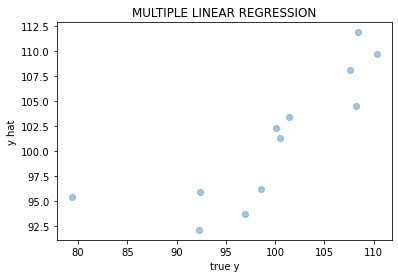

In [30]:
# test set에 대한 실제값과 예측 값의 추세 확인
plt.scatter(y_test, y_pred, alpha=0.4)
plt.xlabel("true y")
plt.ylabel("y hat")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.show()

* model evaluating

In [33]:
print("R square: ", model_lr.score(X_train, y_train))
print("training MSE: ", mean_squared_error(y_train, model_lr.predict(X_train)))
print("test MSE: ", mean_squared_error(y_test, y_pred))

R square:  0.896358165066427
training MSE:  8.263406601718215
test MSE:  26.720798327335885


## Step4. Validate

여러 모델들을 활용하여, validating 하는 단계

## Step5. Visulization
### weekly record 예측하기(weekly CCSI)

In [36]:
# weekly 레코드들을 예측모델에 집어넣어, 각 레코드에 대한 예측값 얻음
pred_ccsi = model_lr.predict(predictors[['keyword1','keyword2','keyword3','keyword4','keyword5','google','naver']])

In [37]:
tmp = pd.merge(predictors, ccsi).drop(['id'], axis=1)
tmp['pred'] = pred_ccsi
tmp.head()

,year,month,day,keyword1,keyword2,keyword3,keyword4,keyword5,google,naver,ccsi,pred
0,2016,1,4,825,419,437,986,168,53.0,26.05846,99.5,103.811404
1,2016,1,11,770,348,351,626,182,58.0,25.16599,99.5,100.783424
2,2016,1,18,918,422,441,445,147,74.0,27.38639,99.5,93.891167
3,2016,1,25,1067,425,567,383,148,59.0,24.72622,99.5,89.437153
4,2016,2,1,899,341,485,289,110,63.0,23.01888,97.2,93.940895


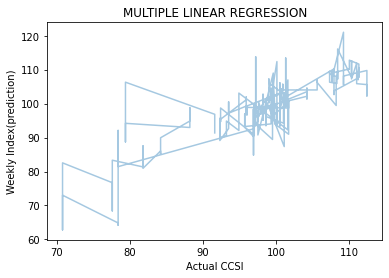

In [38]:
# true와 pred의 추세 확인
plt.plot(tmp['ccsi'], tmp['pred'], alpha=0.4)
plt.xlabel("Actual CCSI")
plt.ylabel("Weekly Index(prediction)")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.show()

In [41]:
# weekly별 단기지표 값에 대한 MSE
print("MSE about weekly CCSI: ", mean_squared_error(tmp['ccsi'], tmp['pred']))

MSE about weekly CCSI:  25.63457351849069


### visaulization
* 시계열 그래프

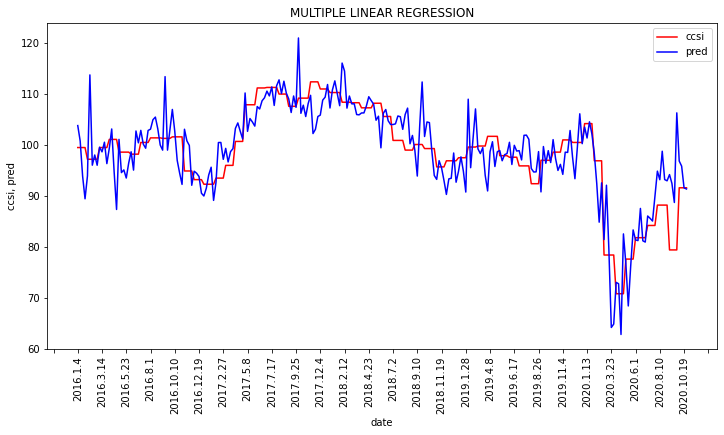

In [42]:
# 시계열 그래프를 그리기위해, 날짜 column 생성
tmp['date'] = tmp[['year', 'month', 'day']].apply(lambda x: '.'.join(map(str, x)), axis=1)

plt.rcParams["figure.figsize"] = (12, 6)
plt.plot(tmp['date'], tmp['ccsi'], color = 'red', label = 'ccsi')
plt.plot(tmp['date'], tmp['pred'], color = 'blue', label = 'pred')
plt.xlabel("date")
plt.ylabel("ccsi, pred")
ax = plt.subplot()
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
for label in ax.xaxis.get_ticklabels() :
    label.set_rotation(90)
plt.title("MULTIPLE LINEAR REGRESSION")
plt.legend()
plt.show()

* moving avg 시계열 그래프

2주 간의 단기 지표들을 평균낸 값을 weekly CCSI로 활용하고자함. <br>
시각화 결과, 주간 레코드에 대한 예측 결과를 바로 활용하는 것 보다 2주 간의 예측 결과 평균을 활용하는 것이 덜 들쑥날쑥하다.

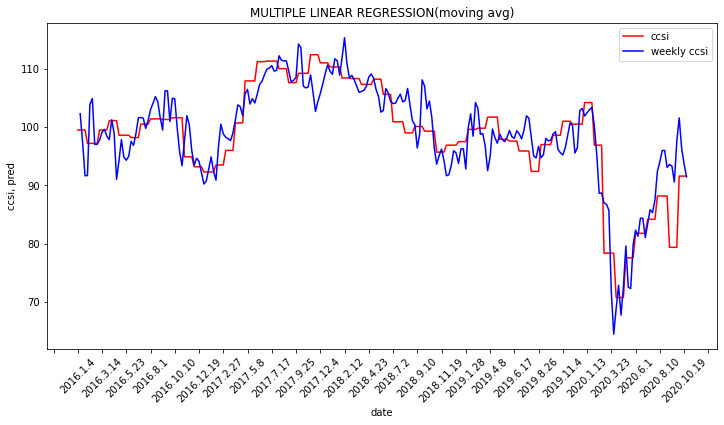

In [43]:
rolling = pd.Series.rolling(tmp['pred'], window = 2, center = False).mean()

plt.rcParams["figure.figsize"] = (12, 6)
plt.plot(tmp['date'], tmp['ccsi'], color = 'red', label = 'ccsi')
rolling.plot(color = 'blue', label = 'weekly ccsi')
plt.xlabel("date")
plt.ylabel("ccsi, pred")
ax = plt.subplot()
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
for label in ax.xaxis.get_ticklabels() :
    label.set_rotation(45)
plt.title("MULTIPLE LINEAR REGRESSION(moving avg)")
plt.legend()
plt.show()